In [ ]:
import numpy as np
import pandas as pd
import holoviews as hv

from holoviews.util.transform import dim
from holoviews.selection import link_selections
from holoviews.operation import gridmatrix
from holoviews.operation.element import histogram
from holoviews import opts

hv.extension('bokeh', 'plotly', width=100)

### JavaScript-based linked brushing

Datasets very often have more dimensions than can be shown in a single plot, which is why HoloViews offers so many ways to show the data from each of these dimensions at once (via layouts, overlays, grids, holomaps, etc.). However, even once the data has been displayed, it can be difficult to relate data points between the various plots that are laid out together. For instance, "is the outlier I can see in this x,y plot the same datapoint that stands out in this w,z plot"? "Are the datapoints with high x values in this plot also the ones with high w values in this other plot?" Since points are not usually visibly connected between plots, answering such questions can be difficult and tedious, making it difficult to understand multidimensional datasets. [Linked brushing](https://infovis-wiki.net/wiki/Linking_and_Brushing) (also called "brushing and linking") offers an easy way to understand how data points and groups of them relate across different plots. Here "brushing" refers to selecting data points or ranges in one plot, with "linking" then highlighting those same points or ranges in other plots derived from the same data.

As an example, consider the standard "autompg" dataset:

In [ ]:
from bokeh.sampledata.autompg import autompg
autompg

This dataset contains specifications for 392 different types of car models from 1970 to 1982. Each car model represents a particular point in a nine-dimensional space, with a certain **mpg**, **cyl**, **displ**, **hp**, **weight**, **accel**, **yr**, **origin**, and **name**. We can use a [gridmatrix](http://holoviews.org/gallery/demos/bokeh/iris_density_grid.html) to see how each numeric dimension relates to the others:

In [ ]:
autompg_ds = hv.Dataset(autompg, ['yr', 'name', 'origin'])

mopts = opts.Points(size=2, tools=['box_select','lasso_select'], active_tools=['box_select'])

gridmatrix(autompg_ds, chart_type=hv.Points).opts(mopts)

These plots show all sorts of interesting relationships already, such as that weight and horsepower are highly positively correlated (locate _weight_ along one axis and _hp_ along the other, and you can see that car models with high weight almost always have high horsepower and vice versa).

What if we want to focus specifically on the subset of cars that have 4 cylinders (*cyl*)? You can do that by pre-filtering the dataframe in Python, but questions like that can be answered immediately using linked brushing, which is automatically supported by `gridmatrix` plots like this one. First, make sure the "box select" or "lasso select" tool is selected in the toolbar:

<img src="https://bokeh.pydata.org/en/latest/_images/BoxSelect.png"><img src="https://bokeh.pydata.org/en/latest/_images/LassoSelect.png">

Then pick one of the points plots labeled _cyl_ and use the selection tool to select all the values where _cyl_ is 4. All of those points in each plot should remain blue, while the points where _cyl_ is not 4 become more transparent: 

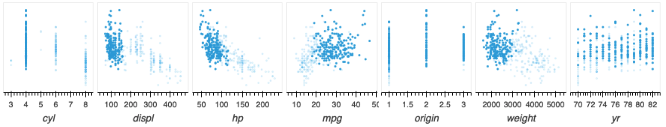

You should be able to see that 4-cylinder models have low displacement (*displ*), low horsepower (*hp*), and low weight, but tend to have higher fuel efficiency (*mpg*). Repeatedly selecting subsets of the data in this way can help you understand properties of a multidimensional dataset that may not be visible in the individual plots, without requiring coding and examining additional plots.

# Python-based linked brushing

The above example illustrates Bokeh's very useful automatic JavaScript-based [linked brushing](https://docs.bokeh.org/en/latest/docs/user_guide/interaction/linking.html#linked-brushing), which can be enabled for Bokeh plots sharing a common data source (as in the `gridmatrix` call) by simply adding a selection tool. However, this approach offers only a single type of selection, and is not available for Python-based data-processing pipelines such as those using [Datashader](15-Large_Data.ipynb).

To get more power and flexibility (at the cost of requiring a Python server for deployment if you weren't already), HoloViews provides a Python-based implementation of linked brushing. HoloViews linked brushing lets you fully customize what elements are used and how linking behaves. Here, let's make a custom Layout displaying some Scatter plots for just a few of the available dimensions:

In [ ]:
colors = hv.Cycle('Category10').values
dims   = ["cyl", "displ", "hp", "mpg", "weight", "yr"]

layout = hv.Layout([
    hv.Points(autompg_ds, dims).opts(color=c)
    for c, dims in zip(colors, [[d,'accel'] for d in dims])
])

print(layout)

Now that we have a layout we can simply apply the `link_selections` operation to support linked brushing,  automatically linking the selections across an arbitrary collection of plots that are derived from the same dataset:

In [ ]:
link_selections(layout).opts(opts.Points(width=200, height=200)).cols(6)

The same `box_select` and `lasso_select` tools should now work as for the `gridmatrix` plot, but this time by calling back to Python. There are now many more options and capabilities available, as described below, but by default you can now also select additional regions in different elements, and the selected points will be those that match _all_ of the selections, so that you can precisely specify the data points of interest with constraints on _all_ dimensions at once. A bounding box will be shown for each selection, but only the overall selected points (across all selection dimensions) will be highlighted in each plot. You can use the reset tool to clear all the selections and start over.

## Box-select vs Lasso-select

Since HoloViews version 1.13.3 linked brushing supports both the `box_select` and `lasso_select` tools. The lasso selection provides more fine-grained control about the exact region to include in the selection, however it is a much more expensive operation and will not scale as well to very large columnar datasets. Additionally lasso select has a number of dependencies:

* Lasso-select on tabular data requires either `spatialpandas` or `shapely`
* Lasso-select on gridded data requires `datashader`
* Lasso-select on geometry data requires `shapely`

### Filter and selection modes

Two parameters of `link_selections` control how the selections apply within a single element (the `selection_mode`) and across elements (the `cross_filter_mode`):

* `selection_mode`: Determines how to combine successive selections on the same element, either `'overwrite'` (the default, allowing one selection per element), `'intersect'` (taking the intersection of all selections for that element), `'union'` (the combination of all selections for that element), or `'inverse'` (select all _but_ the selection region).
* `cross_filter_mode`: Determines how to combine selections across different elements, either `'overwrite'` (allows selecting on only a single element at a time) or `'intersect'` (the default, combining selections across all elements).

To see how these work, we will create a number of views of the autompg dataset:

In [ ]:
w_accel_scatter = hv.Scatter(autompg_ds, 'weight', 'accel')
mpg_hist = histogram(autompg_ds, dimension='mpg', normed=False).opts(color="green")
violin = hv.Violin(autompg_ds, [], 'hp')

We will also capture an "instance" of the `link_selections` operation, which will allow us to access and set parameters on it even after we call it:

In [ ]:
mpg_ls = link_selections.instance()

mpg_ls(w_accel_scatter + mpg_hist + violin)

Here you can select on both the Scatter plot and the Histogram. With these default settings, selecting on different elements computes the intersection of the two selections, allowing you to e.g. select only the points with high weight but mpg between 20 and 30. In the Scatter plot, the selected region will be shown as a rectangular bounding box, with the unselected points inside being transparent. On the histogram, data points selected on the histogram but not in other selections will be drawn in gray, data points not selected on either element will be transparent, and only those points that are selected in _both_ plots will be shown in the default blue color. The Violin plot does not itself allow selections, but it will update to show the distribution of the selected points, with the original distribution being lighter (more transparent) behind it for comparison. Here, selecting high weights and intermediate mpg gives points with a lower range of horsepower in the Violin plot.

The way this all works is for each selection to be collected into a shared "selection expression" that is then applied by every linked plot after any change to a selection:

In [ ]:
mpg_ls.selection_expr

e.g. a box selection on the *weight*,*accel* scatter element might look like this:

```
(((dim('weight') >= (3125.237)) & (dim('weight') <= (3724.860))) & (dim('accel') >= (13.383))) & (dim('accel') <= (19.678))
```

Additional selections in other plots add to this list of filters if enabled, while additional selections within the same plot are combined with an operator that depends on the `selection_mode`.

To better understand how to configure linked brushing, let's create a [Panel](https://panel.holoviz.org) that makes widgets for the parameters of the `linked_selection` operation and lets us explore their effect interactively. Play around with different `cross_filter_mode` and `selection_mode` settings and observe their effects (hitting reset when needed to get back to an unselected state):

In [ ]:
import panel as pn

mpg_lsp = link_selections.instance()

params = pn.Param(mpg_lsp, parameters=[
    'cross_filter_mode', 'selection_mode', 'show_regions',
    'selected_color', 'unselected_alpha', 'unselected_color'])

pn.Row(params, mpg_lsp(w_accel_scatter + mpg_hist + violin))

Note that in recent versions of Bokeh (>=2.1.0) and HoloViews (1.13.4) it is also possible to toggle the selection mode directly in the Bokeh toolbar by toggling the menu on the box-select and lasso-select tools:

<img src="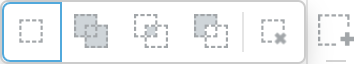
"></img>

### Index-based selections

So far we have worked entirely using range-based selections, which result in selection expressions based only on the axis ranges selected, not the actual data points. Range-based selection requires that all selectable dimensions are present on the datasets behind every plot, so that the selection expression can be evaluated to filter every plot down to the correct set of data points. Range-based selections also only support the `box_select` tool, as they are filtering the data based on a rectangular region of the visible space in that plot. (Of course, you can still combine multiple such boxes to build up to selections of other shapes, with `selection_mode='union'`.)

You can also choose to use index-based selections, which generate expressions based not on axis ranges but on values of one or more index columns (selecting individual, specific data points, as for the Bokeh JavaScript-based linked brushing). For index-based selections, plots can be linked as long as the datasets underlying each plot all have those index columns, so that expressions generated from a selection on one plot can be applied to all of the plots. Ordinarily the index columns should be unique in combination (e.g. Firstname,Lastname), each specifying one particular data point out of your data so that it can be correlated across all plots.

To use index-based selections, specify the `index_cols` that are present across your elements. In the example below we will load the shapes and names of counties from the US state of Texas and their corresponding unemployment rates. We then generate a choropleth plot and a histogram plot both displaying the unemployment rate.

In [ ]:
from bokeh.sampledata.us_counties import data as counties
from bokeh.sampledata.unemployment import data as unemployment

counties = [dict(county, Unemployment=unemployment[cid])
            for cid, county in counties.items()
            if county["state"] == "tx"]

choropleth = hv.Polygons(counties, ['lons', 'lats'], [('detailed name', 'County'), 'Unemployment'])
hist = choropleth.hist('Unemployment', adjoin=False, normed=False)

To link the two we will specify the `'detailed name'` column as the `index_cols`.

In [ ]:
linked_choropleth = link_selections(choropleth + hist, index_cols=['detailed name'])

Now that the two plots are linked we can display them and select individual polygons by tapping or apply a box selection on the histogram:

In [ ]:
linked_choropleth.opts(
    hv.opts.Polygons(tools=['hover', 'tap', 'box_select'], xaxis=None, yaxis=None,
                   show_grid=False, show_frame=False, width=500, height=500,
                   color='Unemployment', colorbar=True, line_color='white'),
    hv.opts.Histogram(width=500, height=500)
)

This type of linked brushing will work even for datasets not including the latitude and longitude axes of the choropleth plot, because each selected county resolves not to a geographic region but to a county name, which can then be used to index into any other dataset that includes the county name for each data point.

### Styling selections

By default, unselected objects will be indicated using a lower alpha value specified using the `unselected_alpha` keyword argument, which keeps unselected points the same color but makes them fade into the background. That way it should be safe to call `link_selections` on a plot without altering its visual appearance by default; you'll only see a visible difference once you select something. An alternative is to specify `selected_color` and an `unselected_color`, which can provide a more vivid contrast between the two states. To make sure both colors are visible ensure you also need to override the `unselected_alpha`:

In [ ]:
link_selections(w_accel_scatter + mpg_hist, selected_color='#ff0000', unselected_alpha=1, unselected_color='#90FF90')

### Plotly support

Linked brushing also works with the Plotly backend, which, unlike Bokeh, has support for rendering 3D plots:

In [ ]:
hv.Store.set_current_backend('plotly')

ds = hv.Dataset(autompg)

sel = link_selections.instance(
    selected_color='#bf0000', unselected_color='#ff9f9f', unselected_alpha=1
)

scatter1 = hv.Scatter(ds, 'weight', 'accel')
scatter2 = hv.Scatter(ds, 'mpg', 'displ')
scatter3d = hv.Scatter3D(ds, ['mpg', 'hp', 'weight'])
table = hv.Table(ds, ['name', 'origin', 'yr'], 'mpg')

sel(scatter1 + scatter2 + scatter3d + table, selection_expr=((dim('origin')==1) & (dim('mpg') >16))).cols(2)

In [ ]:
hv.Store.set_current_backend('bokeh')

Note that Plotly does not yet support _selecting_ in 3D, but you should be able to provide 2D views for selecting alongside the 3D plots.

### Operations

One of the major advantages linked selections in HoloViews provide over using plotting libraries directly is the fact that HoloViews keeps track of the full pipeline of operations that have been applied to a dataset, allowing selections to be applied to the original dataset and then replaying the entire processing pipeline.

In the example below, we'll use an example from [Datashader](https://datashader.org/getting_started/Pipeline.html) that has a sum of five normal distributions of different widths, each with its own range of values and its own category:

In [ ]:
import datashader as ds
import holoviews.operation.datashader as hd

num = 100000
np.random.seed(1)

dists = {
    cat: pd.DataFrame({
        'x': np.random.normal(x, s, num), 
        'y': np.random.normal(y, s, num), 
        'val': np.random.normal(val, 1.5, num), 
        'cat': cat
    }) for x,  y,  s,  val, cat in 
     [(  2,  2, 0.03, 10, "d1"), 
      (  2, -2, 0.10, 20, "d2"), 
      ( -2, -2, 0.50, 30, "d3"), 
      ( -2,  2, 1.00, 40, "d4"), 
      (  0,  0, 3.00, 50, "d5")]
}

points = hv.Points(pd.concat(dists), ['x', 'y'], ['val', 'cat'])
datashaded = hd.datashade(points, aggregator=ds.count_cat('cat'))
spreaded = hd.dynspread(datashaded, threshold=0.50, how='over')

# Declare dim expression to color by cluster
dim_expr = ((0.1+hv.dim('val')/10).round()).categorize(hv.Cycle('Set1').values)
histogram = points.hist(num_bins=60, adjoin=False, normed=False).opts(color=dim_expr)

link_selections(spreaded + histogram)

Here you can select a group of points on the datashaded plot (left) and see that the histogram updates to show that subset of points, and similarly you can select one or more groups in the histogram and see that the corresponding group of points is highlighted on the left. (Here we've color-coded the histogram to make it easy to see that relationship, i.e. that the small dot of red points has a `val` around 10, and the large cloud of orange points has a `val` around 50; usually such relationships won't be so easy to see!) Each time you make such a selection on either plot, the entire 2D spatial aggregation pipeline from Datashader is re-run on the first plot and the entire 1D aggregation by value is run on the second plot, allowing you to see how the subset of `x`,`y` and/or `val` values relates to the dataset as a whole. At no point is the actual data (100,000 points here) sent to the browser, but the browser still allows selecting against the original dataset so that all aggregate views of the data accurately reflect the selection.

### Supported elements

Not all elements can be used with the `link_selections` function, and those that do can support either being selected on (for range and/or index selections), displaying selections, or neither. Below we show most elements supporting range-based selections:

In [ ]:
colors = hv.Cycle('Category10').values

area         = autompg_ds.aggregate('yr', function=np.mean).to(hv.Area, 'yr', 'weight')
bivariate    = hv.Bivariate(autompg_ds, ['mpg', 'accel'], []).opts(show_legend=False)
box_whisker  = hv.BoxWhisker(autompg_ds, 'cyl', 'accel').sort()
curve        = autompg_ds.aggregate('yr', function=np.mean).to(hv.Curve, 'yr', 'mpg')
spread       = autompg_ds.aggregate('yr', function=np.mean, spreadfn=np.std).to(hv.Spread, 'yr', ['mpg', 'mpg_std'])
distribution = hv.Distribution(autompg_ds, 'weight')
img          = hd.rasterize(hv.Points(autompg_ds, ['hp', 'displ']), dynamic=False, width=20, height=20)
heatmap      = hv.HeatMap(autompg_ds, ['yr', 'origin'], 'accel').aggregate(function=np.mean)
hextiles     = hv.HexTiles(autompg_ds, ['weight', 'displ'], []).opts(gridsize=20)
hist         = autompg_ds.hist('displ', adjoin=False, normed=False)
scatter      = hv.Scatter(autompg_ds, 'mpg', 'hp')
violin       = hv.Violin(autompg_ds, 'origin', 'mpg').sort()

link_selections(
    area + bivariate + box_whisker + curve +
    distribution + heatmap + hextiles + hist +
    img + scatter + spread + violin
).opts(
    opts.Area(color=colors[0]),
    opts.Bivariate(cmap='Blues'),
    opts.BoxWhisker(box_color=colors[1]),
    opts.Curve(color=colors[2]),
    opts.Distribution(color=colors[3]),
    opts.HexTiles(cmap='Purples'),
    opts.HeatMap(cmap='Greens'),
    opts.Histogram(color=colors[4]),
    opts.Image(cmap='Reds'),
    opts.Scatter(color=colors[5]),
    opts.Spread(color=colors[6]),
    opts.Violin(violin_fill_color=colors[7]),
)

The table below can be used for reference to see which elements support displaying selections, making index-based selections, and making range-based selections. Elements that do not support selection are not listed in the table at all, including **Div**, **ItemTable**, and **Tiles** along with Annotations (**Arrow**, **Bounds**, **Box**, **Ellipse**, **HLine**, **HSpan**, **Slope**, **Spline**, **Text**, **VLine**, **VSpan**). Notes are provided for some elements that _could_ be supported, but are not yet supported due to various complications as listed.

<style type="text/css">.arbit .trary a { color: inherit; }.arbit .trary
.sL{text-align:center;padding:2px 2px 2px 2px;background-color:#ffffff;font-weight:bold;width:60px}.arbit .trary
.sG{text-align:center;padding:2px 2px 2px 2px;background-color:#ffffff;font-weight:bold}.arbit .trary
.sY{text-align:center;padding:2px 2px 2px 2px;background-color:#b7e1cd;}.arbit .trary 
.sN{text-align:center;padding:2px 2px 2px 2px;background-color:#f4c7c3;}.arbit .trary
.sM{text-align:center;padding:2px 2px 2px 2px;background-color:#fce8b2;}.arbit .trary
</style>

<div class="arbit">
<table class="trary" cellspacing="0" cellpadding="0">
<thead><tr>
<th class="sL">Element</th>
<th class="sL">Display selections</th>
<th class="sL">Index-based selections</th>
<th class="sL">Range-based selections</th>
<th class="sL">Lasso-based selections</th>
<th class="sL">Notes</th>
</tr></thead>
<tbody>

<tr><td class="sG">Area</td><td          class="sY">Yes</td><td class="sY">Yes</td><td class="sY">Yes</td>
    <td class="sN">No </td></tr>
<tr><td class="sG">Bars</td><td          class="sN">No </td><td class="sN">No </td><td class="sN">No </td>
    <td class="sN">No </td><td>Complicated to support stacked and multi-level bars</td></tr>
<tr><td class="sG">Bivariate</td><td     class="sY">Yes</td><td class="sY">Yes</td><td class="sY">Yes</td>
    <td class="sY">Yes </td></tr>
<tr><td class="sG">BoxWhisker</td><td    class="sY">Yes</td><td class="sY">Yes</td><td class="sY">Yes</td>
    <td class="sN">No </td></tr>
<tr><td class="sG">Chord</td><td         class="sN">No </td><td class="sN">No </td><td class="sN">No </td>
    <td class="sN">No </td><td>Complicated to support composite elements</td>
<tr><td class="sG">Contours</td><td      class="sY">Yes</td><td class="sY">Yes</td><td class="sN">No </td>
    <td class="sY">Yes </td></tr>
<tr><td class="sG">Curve</td><td         class="sY">Yes</td><td class="sY">Yes</td><td class="sY">Yes</td>
    <td class="sN">No </td></tr>
<tr><td class="sG">Distribution</td><td  class="sY">Yes</td><td class="sY">Yes</td><td class="sY">Yes</td>
    <td class="sN">No </td></tr>
<tr><td class="sG">ErrorBars</td><td     class="sY">Yes</td><td class="sN">No </td><td class="sN">No </td>
    <td class="sN">No </td></tr>
<tr><td class="sG">Graph</td><td         class="sN">No </td><td class="sN">No </td><td class="sN">No </td>
    <td class="sY">Yes </td><td>Complicated to support composite elements</td></tr>
<tr><td class="sG">HeatMap</td><td       class="sY">Yes</td><td class="sY">Yes</td><td class="sY">Yes</td>
    <td class="sY">Yes </td></tr>
<tr><td class="sG">HexTiles</td><td      class="sY">Yes</td><td class="sY">Yes</td><td class="sY">Yes</td>
    <td class="sY">Yes </td></tr>
<tr><td class="sG">Histogram</td><td     class="sY">Yes</td><td class="sY">Yes</td><td class="sY">Yes</td>
    <td class="sN">No </td></tr>
<tr><td class="sG">HSV</td><td           class="sY">Yes</td><td class="sY">Yes</td><td class="sY">Yes</td>
    <td class="sY">Yes </td></tr>
<tr><td class="sG">Image</td><td         class="sY">Yes</td><td class="sY">Yes</td><td class="sY">Yes</td>
    <td class="sY">Yes </td></tr>
<tr><td class="sG">Labels</td><td        class="sY">Yes</td><td class="sN">No </td><td class="sN">No </td>
    <td class="sY">Yes </td></tr>
<tr><td class="sG">Path3D</td><td        class="sN">No </td><td class="sN">No </td><td class="sN">No </td>
    <td class="sN">No </td><td>Complicated to support masking partial paths; no 3D selections</td></tr>
<tr><td class="sG">Path</td><td          class="sN">No </td><td class="sN">No </td><td class="sN">No </td>
    <td class="sN">No </td><td>Complicated to support masking partial paths</td></tr>
<tr><td class="sG">Points</td><td        class="sY">Yes</td><td class="sY">Yes</td><td class="sY">Yes</td>
    <td class="sY">Yes </td></tr>
<tr><td class="sG">Polygons</td><td      class="sY">Yes</td><td class="sY">Yes</td><td class="sN">No </td>
    <td class="sY">Yes </td></tr>
<tr><td class="sG">QuadMesh</td><td      class="sY">Yes</td><td class="sY">Yes</td><td class="sY">Yes</td>
    <td class="sY">Yes </td></tr>
<tr><td class="sG">RadialHeatMap</td><td class="sY">Yes</td><td class="sN">No </td><td class="sN">No </td>
    <td class="sN">No </td></tr>
<tr><td class="sG">Raster</td><td        class="sN">No </td><td class="sN">No </td><td class="sN">No </td>
    <td class="sN">No </td><td>Special-case code that is difficult to replace</td></tr>
<tr><td class="sG">Rectangles</td><td    class="sY">Yes</td><td class="sY">Yes</td><td class="sY">Yes</td>
    <td class="sY">Yes </td></tr>
<tr><td class="sG">RGB</td><td           class="sY">Yes</td><td class="sY">Yes</td><td class="sY">Yes</td>
    <td class="sY">Yes </td></tr>
<tr><td class="sG">Sankey</td><td        class="sN">No </td><td class="sN">No </td><td class="sN">No </td>
    <td class="sN">No </td><td>Complicated to support composite elements</td></tr>
<tr><td class="sG">Scatter</td><td       class="sY">Yes</td><td class="sY">Yes</td><td class="sY">Yes</td>
    <td class="sY">Yes </td></tr>
<tr><td class="sG">Scatter3D</td><td     class="sY">Yes</td><td class="sN">No </td><td class="sN">No </td>
    <td class="sN">No </td><td>3D selections not yet available</td></tr>
<tr><td class="sG">Segments</td><td      class="sY">Yes</td><td class="sY">Yes</td><td class="sY">Yes</td>
    <td class="sY">Yes </td></tr>
<tr><td class="sG">Spikes</td><td        class="sY">Yes</td><td class="sY">Yes</td><td class="sY">Yes</td>
    <td class="sN">No </td></tr>
<tr><td class="sG">Spread</td><td        class="sY">Yes</td><td class="sY">Yes</td><td class="sY">Yes</td>
    <td class="sN">No </td></tr>
<tr><td class="sG">Surface</td><td       class="sY">Yes</td><td class="sN">No </td><td class="sN">No </td>
    <td class="sN">No </td><td>3D selections not yet available</td></tr>
<tr><td class="sG">Table</td><td         class="sY">Yes</td><td class="sY">Yes</td><td class="sN">No </td>
    <td class="sN">No </td></tr>
<tr><td class="sG">TriMesh</td><td       class="sN">No </td><td class="sN">No </td><td class="sN">No </td>
    <td class="sN">No </td><td>Complicated to support composite elements</td></tr>
<tr><td class="sG">TriSurface</td><td    class="sY">Yes</td><td class="sN">No </td><td class="sN">No </td>
    <td class="sN">No </td><td>3D selections not yet available</td></tr>
<tr><td class="sG">VectorField</td><td   class="sY">Yes</td><td class="sY">Yes</td><td class="sY">Yes</td>
    <td class="sY">Yes </td></tr>
<tr><td class="sG">Violin</td><td        class="sY">Yes</td><td class="sY">Yes</td><td class="sY">Yes</td>
    <td class="sN">No </td></tr>

</tbody></table></div>